In [38]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
import time
from scipy.stats import chi2
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Datasets

In [56]:
def dataset_1(random_state=42):
    X, y = make_classification(
        n_samples=10000,
        n_features=10,
        n_informative=5,
        n_redundant=2,
        n_classes=2,
        random_state=random_state
    )

    discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
    X = discretizer.fit_transform(X)
    return X, y

In [57]:
def dataset_2(random_state=42):
    np.random.seed(random_state)
    X = np.random.randint(0, 2, (1000, 100))
    y = ((X[:, 0] ^ X[:, 1]) | (X[:, 2] & X[:, 3] & X[:, 4])).astype(int)
    return X, y

In [65]:
def dataset_3(random_state=42):
    n = 1000
    p = 14
    k = 6

    np.random.seed(random_state)
    X = np.random.randn(n, p)
    chisq_median = chi2.median(k)
    y = ((X[:, :k]**2).sum(axis=1) > chisq_median).astype(int)

    return X, y

# Filters

In [66]:
def gini(X, y):
    data = []
    for col in range(X.shape[1]):
        temp_df = pd.DataFrame({'X': X[:, col], 'y': y})
        x_y_count = temp_df.groupby(['X', 'y'])['y'].count()
        x_count = temp_df.groupby('X').count()['y']
        gini_vals = 1 - ((x_y_count / x_count)**2).groupby('X').sum()
        gini_val = (x_count * gini_vals / X.shape[0]).sum()
        data.append({'feature': col, 'gini': gini_val})
    return pd.DataFrame(data)

def gini_method(X, y, top_k=5):
    chosen_features = gini(X, y).sort_values('gini')['feature'].to_numpy()[:top_k]
    return chosen_features

In [67]:
def mutual_info(X, y):
    mi = mutual_info_classif(X, y, discrete_features='auto')
    return pd.DataFrame({
        'feature': np.arange(X.shape[1]),
        'mutual_info': mi
    })

def mutual_info_method(X, y, top_k=5):
    mi_df = mutual_info(X, y).sort_values('mutual_info', ascending=False)
    return mi_df['feature'].to_numpy()[:top_k]


# Wrapper

In [68]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

def rfe(X, y):
    estimator = SVR(kernel='linear')
    rfe = RFE(estimator, n_features_to_select=5, step=1)
    rfe.fit(X, y)
    result = rfe.ranking_
    result = np.where(result == 1)[0]
    return list(result.reshape((-1,)))

# Feature Selection Evaluation

In [69]:
def eval_feature_selection(dataset_method, feature_method, relevant_features, tests=5):
    scores = []
    for i in tqdm(range(tests)):
        X, y = dataset_method(random_state=i)
        chosen_features = feature_method(X, y)
        Rs = len(set(chosen_features).intersection(set(relevant_features)))
        Rt = len(relevant_features)
        Is = len(chosen_features) - Rs
        It = X.shape[1] - len(relevant_features)
        alpha = min(0.5, Rt / It)
        score = (Rs / Rt - alpha * Is / It) * 100
        scores.append(score)
    print(scores)

In [70]:
def compare_feature_selection_methods(tests=5):
    datasets = {
        'Dataset 1': {
            'method': dataset_1,
            'relevant_features': [0, 1, 2, 3, 4]
        },
        'Dataset 2': {
            'method': dataset_2,
            'relevant_features': [0, 1, 2, 3, 4]
        },
        'Dataset 3': {
            'method': dataset_3,
            'relevant_features': list(range(6))
        }
    }
    
    methods = {
        'Gini': gini_method,
        'Mutual Info': mutual_info_method,
        'RFE': rfe
    }
    
    results = []
    
    for dataset_name, dataset_info in datasets.items():
        for method_name, method_func in methods.items():
            print(f"Testing {method_name} on {dataset_name}...")
            scores = []
            for i in tqdm(range(tests)):
                X, y = dataset_info['method'](random_state=i)
                chosen_features = method_func(X, y)
                relevant_features = dataset_info['relevant_features']
                
                Rs = len(set(chosen_features).intersection(set(relevant_features)))
                Rt = len(relevant_features)
                Is = len(chosen_features) - Rs
                It = X.shape[1] - len(relevant_features)
                alpha = min(0.5, Rt / It)
                score = (Rs / Rt - alpha * Is / It) * 100
                
                scores.append(score)
            
            for score in scores:
                results.append({
                    'Dataset': dataset_name,
                    'Method': method_name,
                    'Score': score
                })
    
    results_df = pd.DataFrame(results)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=results_df,
        x='Dataset',
        y='Score',
        hue='Method',
        palette='Set2'
    )
    plt.title('Feature Selection Method Performance Comparison', fontsize=16, pad=20)
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('Selection Score', fontsize=12)
    plt.ylim(-20, 120)
    plt.legend(title='Feature Selection Method', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

Testing Gini on Dataset 1...


100%|██████████| 3/3 [00:00<00:00, 19.12it/s]


Testing Mutual Info on Dataset 1...


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Testing RFE on Dataset 1...


100%|██████████| 3/3 [02:42<00:00, 54.33s/it]


Testing Gini on Dataset 2...


100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


Testing Mutual Info on Dataset 2...


100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


Testing RFE on Dataset 2...


100%|██████████| 3/3 [01:47<00:00, 35.71s/it]


Testing Gini on Dataset 3...


100%|██████████| 3/3 [00:00<00:00, 18.54it/s]


Testing Mutual Info on Dataset 3...


100%|██████████| 3/3 [00:00<00:00, 12.78it/s]


Testing RFE on Dataset 3...


100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


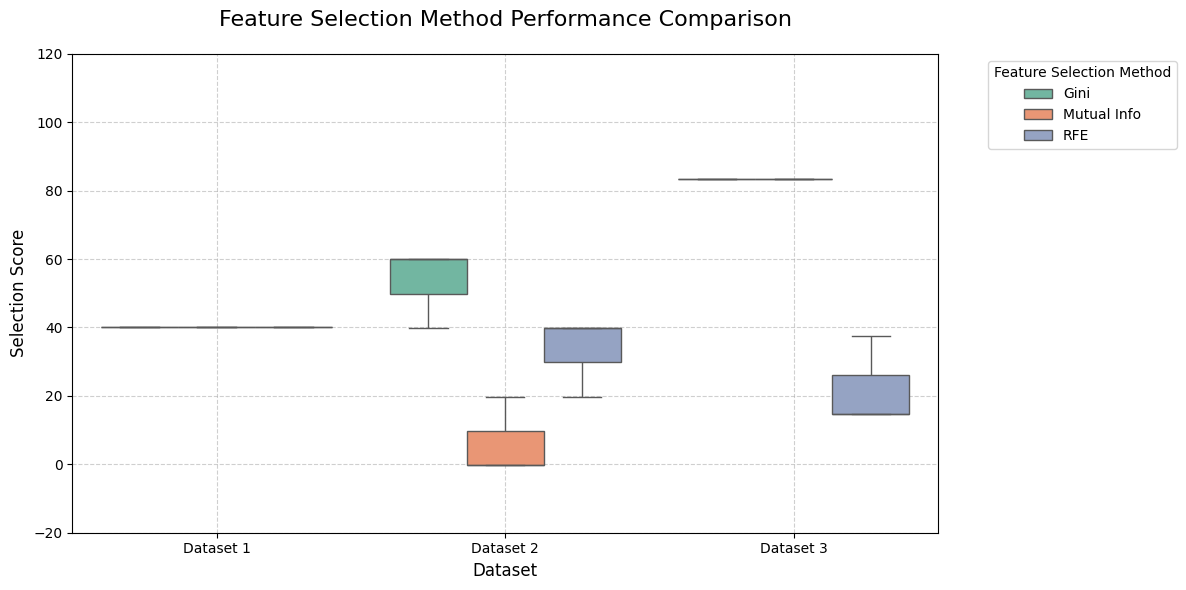

In [71]:
compare_feature_selection_methods(3)

## Evaluate Models

In [82]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = SVC()
model = RandomForestClassifier()
X, y = dataset_1()
feature_mask = [0, 2, 3, 4, 6]
relevant_mask = [0, 1, 2, 3, 4]

In [83]:
def get_metric_data(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    y_test_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    return ({
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

accuracy, precision, recall and F1 score

In [ ]:
def eval_model(model, X, y, feature_mask, relevant_mask):
    def get_metric_data(model, x_train, x_test, y_train, y_test):
        model.fit(x_train, y_train)
        y_test_pred = model.predict(x_test)

        accuracy = accuracy_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        return ({
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        })
    
    kf = KFold(n_splits=50)
    data_full = []
    data_chosen = []
    data_relevant = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        x_train, x_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        data_full.append(get_metric_data(model, x_train, x_test, y_train, y_test))
        data_chosen.append(get_metric_data(model, x_train[:, feature_mask], x_test[:, feature_mask], y_train, y_test))
        data_relevant.append(get_metric_data(model, x_train[:, relevant_mask], x_test[:, relevant_mask], y_train, y_test))
    data_full = pd.DataFrame(data_full)
    data_chosen = pd.DataFrame(data_chosen)
    data_relevant = pd.DataFrame(data_relevant)

    fig, axs = plt.subplots(3, 4, figsize=(16, 12))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    datasets = [
        (data_full, 'Full Feature Set', 'firebrick'),
        (data_chosen, 'Chosen Feature Set', 'gold'),
        (data_relevant, 'Relevant Feature Set', 'seagreen')
    ]

    x_limits = {}
    for col_idx, metric in enumerate(metrics):
        min_val = min(data_full[metric].min(), 
                    data_chosen[metric].min(), 
                    data_relevant[metric].min())
        max_val = max(data_full[metric].max(),
                    data_chosen[metric].max(),
                    data_relevant[metric].max())
        x_limits[col_idx] = (min_val - 0.02, max_val + 0.02)

    for row_idx, (data, label, color) in enumerate(datasets):
        for col_idx, metric in enumerate(metrics):
            sns.histplot(
                data=data,
                x=metric,
                ax=axs[row_idx, col_idx],
                color=color,
                kde=True,
                bins=15,
                alpha=0.4
            )
            
            axs[row_idx, col_idx].set_xlim(x_limits[col_idx])
            
            axs[row_idx, col_idx].grid(True, linestyle='--', alpha=0.6)
            
            if col_idx == 0:
                axs[row_idx, col_idx].set_ylabel(label, fontsize=12, fontweight='bold')
                
            if row_idx == 0:
                axs[row_idx, col_idx].set_title(metric, fontsize=14, fontweight='bold')

    for col_idx, metric in enumerate(metrics):
        axs[2, col_idx].set_xlabel(f'{metric} Value', fontsize=10)

    plt.suptitle('Performance Metrics Distribution Comparison', y=1.02, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [53]:
# eval_model(model,  X, y, [0, 2, 3, 4, 6], [0, 1, 2, 3, 4])

# Dimensionality Reduction

In [72]:
X, y = dataset_1()

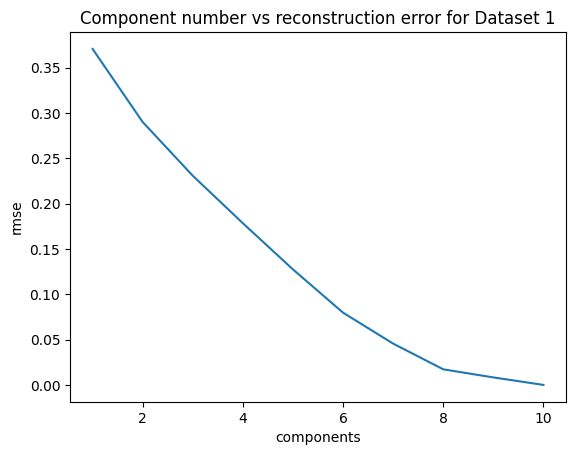

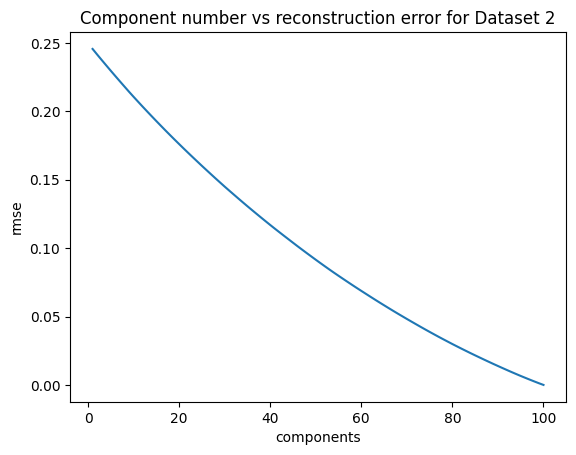

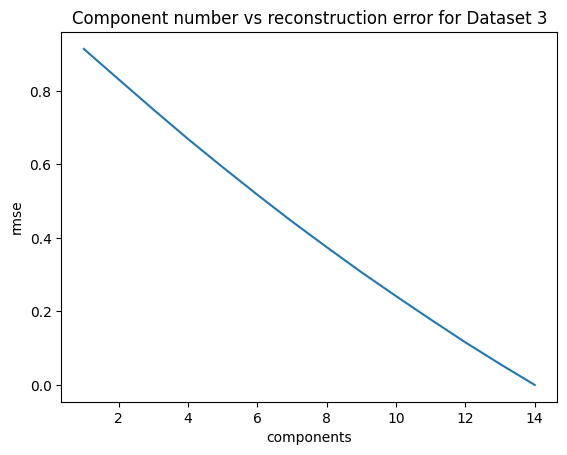

In [89]:
from sklearn.decomposition import PCA
for dataset_method, name in [
    (dataset_1, 'Dataset 1'), 
    (dataset_2, 'Dataset 2'), 
    (dataset_3, 'Dataset 3')]:
    X, y = dataset_method()
    data = []
    for i in range(X.shape[1]):
        pca = PCA(n_components=i+1)
        X_reduced = pca.fit_transform(X)
        X_reconctrucred = pca.inverse_transform(X_reduced)
        rmse = np.mean((X - X_reconctrucred)**2)
        data.append({'components': i+1, 'rmse': rmse})
    data = pd.DataFrame(data)
    sns.lineplot(data, x='components', y='rmse')
    plt.title(f'Component number vs reconstruction error for {name}')
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def eval_dim_reduction_impact(model, X, y, feature_mask, relevant_mask, n_components=2, random_state=42):
    
    def get_metrics(model, x_train, x_test, y_train, y_test):
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        return {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred)
        }
    
    # Initialize dimensionality reduction techniques
    reducers = {
        'PCA': PCA(n_components=n_components, random_state=random_state),
        'MDS': MDS(n_components=n_components, random_state=random_state),
        't-SNE': TSNE(n_components=n_components, random_state=random_state)
    }
    
    kf = KFold(n_splits=5)  # Fewer splits for computational efficiency (adjust as needed)
    results = []
    
    for train_index, test_index in kf.split(X):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Evaluate on original feature sets
        metrics_full = get_metrics(model, x_train, x_test, y_train, y_test)
        metrics_full['Feature Set'] = 'Full Features'
        
        metrics_chosen = get_metrics(model, x_train[:, feature_mask], x_test[:, feature_mask], y_train, y_test)
        metrics_chosen['Feature Set'] = 'Selected Features'
        
        metrics_relevant = get_metrics(model, x_train[:, relevant_mask], x_test[:, relevant_mask], y_train, y_test)
        metrics_relevant['Feature Set'] = 'Relevant Features'
        
        results.extend([metrics_full, metrics_chosen, metrics_relevant])
        
        for name, reducer in reducers.items():
            try:
                x_train_proj = reducer.fit_transform(x_train)
                x_test_proj = reducer.transform(x_test) if hasattr(reducer, 'transform') else reducer.fit_transform(x_test)
                
                metrics_proj = get_metrics(model, x_train_proj, x_test_proj, y_train, y_test)
                metrics_proj['Feature Set'] = f'{name} Projection'
                results.append(metrics_proj)
            except Exception as e:
                print(f"Error with {name}: {e}")
    
    results_df = pd.DataFrame(results)
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=results_df, x='Feature Set', y='F1 Score', palette='viridis')
    plt.title('F1-Score Comparison Across Feature Sets and Dimensionality Reduction Techniques', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    return results_df